    *************************** CASE STUDY HEALTHCARE DATA ANALYSIS (PART 2) ***********************************

    PART 2: Identify the three providers that are least similar to other providers and the the three regions that 
    are least similar to other region

    #1. Importing Libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as stats
import pandas_profiling

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans

# center and scale the data
from sklearn.preprocessing import StandardScaler

C:\Users\lenovo\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas_profiling\base.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\lenovo\AppData\Local\Continuum\anaconda2\lib\runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "C:\Users\lenovo\AppData\Local\Continuum\anaconda2\lib\runpy.py", line 72, in _run_code
    exec code in run_globals
  File "C:\Users\lenovo\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\lenovo\AppData\Local\Continuum\anaconda2\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()

In [2]:
Medicare_Provider_Charge_In = pd.read_csv('Medicare_Provider_Charge_Inpatient_DRG100_FY2011.csv')
Medicare_Provider_Charge_Out = pd.read_csv('Medicare_Provider_Charge_Outpatient_APC30_CY2011_v2.csv')

    #2. Data Analysis and Data Preparation

    The Data Analysis will be based on financial summary data from 2011 that were made availible by the centers of  Medicare and Medicaid Services
    
    Medicare_Provider_Charge_Inpatient_DRG100_FY2011.csv
    Medicare_Provider_Charge_Outpatient_APC30_CY2011_v2.csv

    A. Performing Data Analysis

In [3]:
Medicare_Provider_Charge_In.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
DRG Definition                                163065 non-null object
Provider Id                                   163065 non-null int64
Provider Name                                 163065 non-null object
Provider Street Address                       163065 non-null object
Provider City                                 163065 non-null object
Provider State                                163065 non-null object
Provider Zip Code                             163065 non-null int64
Hospital Referral Region (HRR) Description    163065 non-null object
Total Discharges                              163065 non-null int64
Average Covered Charges                       163065 non-null float64
Average Total Payments                        163065 non-null float64
Average Medicare Payments                     163065 non-null float64
dtypes: float64(3), int64(3), object(6)
memory usage: 14.9+ M

In [4]:
Medicare_Provider_Charge_Out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43372 entries, 0 to 43371
Data columns (total 11 columns):
APC                                           43372 non-null object
Provider Id                                   43372 non-null int64
Provider Name                                 43372 non-null object
Provider Street Address                       43372 non-null object
Provider City                                 43372 non-null object
Provider State                                43372 non-null object
Provider Zip Code                             43372 non-null int64
Hospital Referral Region (HRR) Description    43372 non-null object
Outpatient Services                           43372 non-null int64
Average  Estimated Submitted Charges          43372 non-null float64
Average Total Payments                        43372 non-null float64
dtypes: float64(2), int64(3), object(6)
memory usage: 3.6+ MB


In [5]:
Medicare_Provider_Charge_In.isnull().any()

DRG Definition                                False
Provider Id                                   False
Provider Name                                 False
Provider Street Address                       False
Provider City                                 False
Provider State                                False
Provider Zip Code                             False
Hospital Referral Region (HRR) Description    False
Total Discharges                              False
Average Covered Charges                       False
Average Total Payments                        False
Average Medicare Payments                     False
dtype: bool

In [6]:
Medicare_Provider_Charge_Out.isnull().any()

APC                                           False
Provider Id                                   False
Provider Name                                 False
Provider Street Address                       False
Provider City                                 False
Provider State                                False
Provider Zip Code                             False
Hospital Referral Region (HRR) Description    False
Outpatient Services                           False
Average  Estimated Submitted Charges          False
Average Total Payments                        False
dtype: bool

In [7]:
pandas_profiling.ProfileReport(Medicare_Provider_Charge_In)

Number of variables,12
Number of observations,163065
Total Missing (%),0.0%
Total size in memory,14.9 MiB
Average record size in memory,96.0 B
Numeric,5
Categorical,6
Date,0
Text (Unique),0
Rejected,1
Distinct count,161985


In [8]:
pandas_profiling.ProfileReport(Medicare_Provider_Charge_Out)

Number of variables,11
Number of observations,43372
Total Missing (%),0.0%
Total size in memory,3.6 MiB
Average record size in memory,88.0 B
Numeric,5
Categorical,6
Date,0
Text (Unique),0
Rejected,0
Distinct count,30


    Based on the data profiling; I subset the columns to be used for further processing -
    
####    Columns to be used to process inpatient data-
        'DRG Definition', 'Provider Name', 'Provider State', 'Hospital Referral Region (HRR) Description',
        'Total Discharges', 'Average Covered Charges' and 'Average Total Payments'
        
####    Columns to be used to process outpatient data -
        'APC', 'Provider Name', 'Provider State', 'Hospital Referral Region (HRR) Description',
        'Outpatient Services', 'Average  Estimated Submitted Charges' and 'Average Total Payments'       

    B. Data Manipulation

    Subsetting and renaming columns to be used for further processing

In [7]:
Medicare_In_data = Medicare_Provider_Charge_In[['DRG Definition', 'Provider Name', 'Provider State', 'Hospital Referral Region (HRR) Description',
                                              'Total Discharges', 'Average Covered Charges', 'Average Total Payments' ]]

In [8]:
Medicare_In_data.rename(columns={'DRG Definition' : 'Procedures', 'Hospital Referral Region (HRR) Description' : 'Region',
                                 'Total Discharges' : 'Count Of Services', 'Average Covered Charges' : 'Charges',
                                 'Average Total Payments' : 'Payment'}, inplace = True)

C:\Users\lenovo\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [9]:
Medicare_Out_data = Medicare_Provider_Charge_Out[['APC', 'Provider Name', 'Provider State', 'Hospital Referral Region (HRR) Description',
                                                 'Outpatient Services', 'Average  Estimated Submitted Charges', 'Average Total Payments' ]]

In [10]:
Medicare_Out_data.rename(columns={'APC' : 'Procedures', 'Hospital Referral Region (HRR) Description' : 'Region',
                                 'Outpatient Services' : 'Count Of Services', 'Average  Estimated Submitted Charges' : 'Charges',
                                 'Average Total Payments' : 'Payment'}, inplace = True)

                    Concating inpatient and Outpatient data
                               And
                    Manipulating merged data

In [11]:
frames = [Medicare_In_data, Medicare_Out_data]
Medicare_data = pd.concat(frames)

In [12]:
Medicare_data.head(5)

,Procedures,Provider Name,Provider State,Region,Count Of Services,Charges,Payment
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SOUTHEAST ALABAMA MEDICAL CENTER,AL,AL - Dothan,91,32963.07692,5777.241758
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,MARSHALL MEDICAL CENTER SOUTH,AL,AL - Birmingham,14,15131.85714,5787.571429
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,ELIZA COFFEE MEMORIAL HOSPITAL,AL,AL - Birmingham,24,37560.37500,5434.958333
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,ST VINCENT'S EAST,AL,AL - Birmingham,25,13998.28000,5417.560000
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SHELBY BAPTIST MEDICAL CENTER,AL,AL - Birmingham,18,31633.27778,5658.333333


In [13]:
Medicare_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206437 entries, 0 to 43371
Data columns (total 7 columns):
Procedures           206437 non-null object
Provider Name        206437 non-null object
Provider State       206437 non-null object
Region               206437 non-null object
Count Of Services    206437 non-null int64
Charges              206437 non-null float64
Payment              206437 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 12.6+ MB


In [14]:
Medicare_data.isnull().any()

Procedures           False
Provider Name        False
Provider State       False
Region               False
Count Of Services    False
Charges              False
Payment              False
dtype: bool

In [15]:
Medicare_data['Charges'] = Medicare_data['Charges'].round(2)

In [16]:
Medicare_data['Payment'] = Medicare_data['Payment'].round(2)

In [17]:
Medicare_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206437 entries, 0 to 43371
Data columns (total 7 columns):
Procedures           206437 non-null object
Provider Name        206437 non-null object
Provider State       206437 non-null object
Region               206437 non-null object
Count Of Services    206437 non-null int64
Charges              206437 non-null float64
Payment              206437 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 12.6+ MB


    C. Grouping data by Provider and Region

    By Provider

In [18]:
Medicare_data_group_provider = Medicare_data.groupby(['Provider Name']).agg({'Procedures' :  'nunique',
                                                                                    'Provider State' : 'nunique', 
                                                                                    'Region': 'nunique',
                                                                                    'Count Of Services': 'sum' , 
                                                                                    'Charges': 'sum' , 
                                                                                    'Payment' : 'sum'})

In [19]:
Medicare_data_group_provider = Medicare_data_group_provider.reset_index()

In [20]:
Medicare_data_group_provider.head()

,Provider Name,Count Of Services,Provider State,Charges,Region,Procedures,Payment
0,ABBEVILLE GENERAL HOSPITAL,1294,1,314058.89,1,25,121115.80
1,ABBOTT NORTHWESTERN HOSPITAL,20810,1,4495571.85,1,121,1065438.89
2,ABILENE REGIONAL MEDICAL CENTER,7285,1,3613719.38,1,71,516580.33
3,ABINGTON MEMORIAL HOSPITAL,19300,1,6832266.25,1,121,1027582.36
4,ACMH HOSPITAL,4151,1,406719.05,1,54,199332.50


    By Region

In [21]:
Medicare_data_group_region = Medicare_data.groupby(['Region']).agg({'Procedures' :  'nunique',
                                                                                    'Provider State' : 'nunique', 
                                                                                    'Provider Name': 'nunique',
                                                                                    'Count Of Services': 'sum' , 
                                                                                    'Charges': 'sum' , 
                                                                                    'Payment' : 'sum'})

In [22]:
Medicare_data_group_region = Medicare_data_group_region.reset_index()

In [23]:
Medicare_data_group_region.head()

,Region,Count Of Services,Provider State,Charges,Provider Name,Procedures,Payment
0,AK - Anchorage,31406,1,9427445.52,9,100,3390445.95
1,AL - Birmingham,166237,2,68364063.11,40,127,14648212.20
2,AL - Dothan,43700,3,9561883.16,10,122,2419670.08
3,AL - Huntsville,71691,2,11754072.47,8,125,3090569.68
4,AL - Mobile,70394,2,16193817.95,14,125,4256181.67


    K Means Clustering is exploratory data analysis technique. 
    This is non-hierarchical method of grouping objects together


    Euclidean  is one of the distance measures used on K Means algorithm.
    Euclidean distance between of a observation and initial cluster centroids  1 and 2 is calculated. 
    Based on euclidean distance each observation is assigned to one of the clusters - based on minimum distance.

![alt text](Euclidean-Distance.png "Title")

    #3. Creating the cluster at Provider level to identify the providers with least similarity

    Based on the cluster analysis follwing 4 Providers stands out as least similar to other providers by K-MEANS
    Analysis
   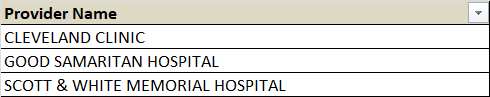


    GOOD SAMARITAN HOSPITAL - 
                                the charges for procuders are highest as compared to other providers; 
                                also it is available at 6 states and 8 regions
                                
    CLEVELAND CLINIC and SCOTT & WHITE MEMORIAL HOSPITAL -
                                they offer highest number of procedures (APC + DRG)

    A. Creating data for fitting into cluster analysis

In [24]:
Medicare_data_group_provider_num = Medicare_data_group_provider.select_dtypes(include =['int64', 'float64']).copy()

In [25]:
col_list_prov = Medicare_data_group_provider_num.columns

    B. Standardizing the data

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
sc=StandardScaler()

In [28]:
Medicare_provider_scaled=sc.fit_transform(Medicare_data_group_provider_num)

    C. Applying PCA
        - 3 clusters are defining 94% of data

In [29]:
from sklearn.decomposition import PCA

In [30]:
var_ratio={}
pc = PCA(n_components=3)
Medicare_provider_pca=pc.fit(Medicare_provider_scaled)
var_ratio[5]=sum(Medicare_provider_pca.explained_variance_ratio_)

In [31]:
reduced_cr=pc.fit_transform(Medicare_provider_scaled)

In [32]:
var_ratio

{5: 0.94596279501992098}

In [33]:
reduced_cr.shape

(3201L, 3L)

In [34]:
Medicare_provider_scaled.shape

(3201L, 6L)

In [36]:
pd.DataFrame(pc.components_.T, columns=['PC_' + str(i) for i in range(3)], index=col_list_prov)

,PC_0,PC_1,PC_2
Count Of Services,0.289998,-0.288352,0.896801
Provider State,0.356879,0.591702,0.086489
Charges,0.464627,-0.172105,-0.354212
Region,0.361007,0.589502,0.074693
Procedures,0.428081,-0.397857,-0.197239
Payment,0.509000,-0.176972,-0.135345


In [37]:
pd.Series(pc.explained_variance_ratio_,index=['PC_' + str(i) for i in range(3)])

PC_0    0.564617
PC_1    0.261370
PC_2    0.119976
dtype: float64

    D. Clustering

#### Silhouette Coefficient

In [38]:
from sklearn import metrics
#metrics.silhouette_score(credit_scaled, km_4.labels_)

In [39]:
# calculate SC for K=3 through K=12
k_range = range(3, 25)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(Medicare_provider_scaled)
    scores.append(metrics.silhouette_score(Medicare_provider_scaled, km.labels_))

In [40]:
scores

[0.52013812264260406,
 0.53558982542917055,
 0.55160562280718961,
 0.45082940343251965,
 0.42797340558229646,
 0.43037379132062831,
 0.43126825936678764,
 0.3970413810656433,
 0.39479686309057327,
 0.39811603295080789,
 0.39954939316357474,
 0.36418744250607787,
 0.36201466759422157,
 0.354977869135085,
 0.35380264307114517,
 0.35471826718683808,
 0.3423794732353157,
 0.33330010173992253,
 0.34624253597643334,
 0.32547032479801724,
 0.33151708272118985,
 0.33365235963459478]

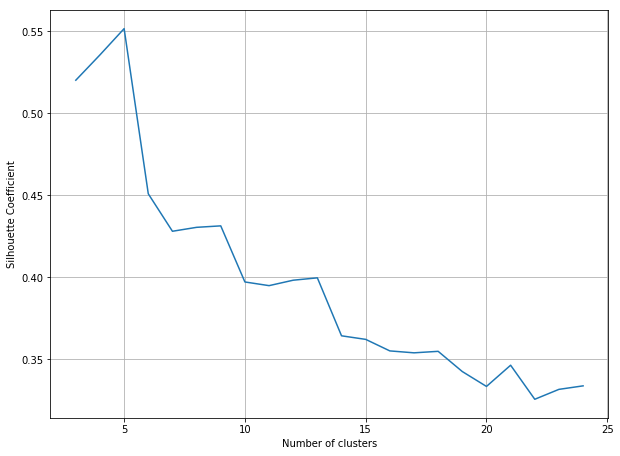

In [41]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

    We will be using Silhouette Coefficient to get the most scattered cluster i.e. least coeffient 
    to get the outliers
    
    Using 22 custers for cluster analysis since it is having least coeffcient

#### For 22 cluster Solution behavior  -

In [42]:
from sklearn.cluster import KMeans

In [43]:
km_22=KMeans(n_clusters=22,random_state=123)

In [44]:
km_22.fit(reduced_cr)
km_22.labels_

array([ 7, 16,  1, ..., 20, 18, 20])

In [45]:
pd.Series(km_22.labels_).value_counts()

7     554
20    517
0     437
14    377
1     361
18    328
16    200
4     146
10     93
15     38
5      31
12     29
9      22
11     22
3      13
13     12
6       6
2       5
21      4
17      3
8       2
19      1
dtype: int64

    From the scatter plot we can clearly see cluster 19 with 1 dot and custer 8 with 2 dots are outliers

Text(0.5,0,u'PC_22')

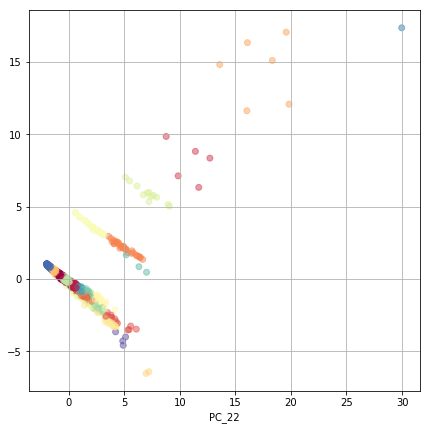

In [46]:
plt.figure(figsize=(7,7))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1], c=km_22.labels_,cmap='Spectral',alpha=0.5)
plt.xlabel('PC_22')

In [47]:
cluster_df_22=pd.concat([Medicare_data_group_provider, pd.Series(km_22.labels_, name='Cluster_22')], axis=1)

In [48]:
cluster_df_22.to_csv('cluster_df_22_2.csv')

    Concluding the follwing provider data are the outliers; with least similarities with others -
    
   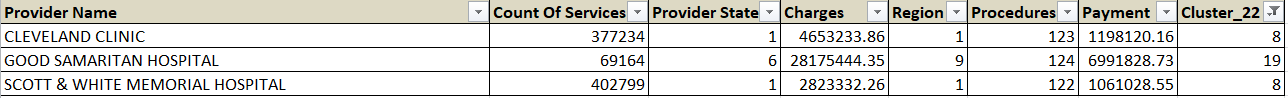

    #4. Creating the cluster at Region level to identify the region with least similarity

    Based on the cluster analysis follwing 4 Providers stands out as least similar to other providers by K-MEANS
    Analysis



In [111]:
Medicare_data_group_region.head()

,Region,Count Of Services,Provider State,Charges,Provider Name,Procedures,Payment
0,AK - Anchorage,31406,1,9427445.52,9,100,3390445.95
1,AL - Birmingham,166237,2,68364063.11,40,127,14648212.20
2,AL - Dothan,43700,3,9561883.16,10,122,2419670.08
3,AL - Huntsville,71691,2,11754072.47,8,125,3090569.68
4,AL - Mobile,70394,2,16193817.95,14,125,4256181.67


    A. Creating data for fitting into cluster analysis

In [112]:
Medicare_data_group_region_num = Medicare_data_group_region.select_dtypes(include =['int64', 'float64']).copy()

In [113]:
col_list_reg = Medicare_data_group_region_num.columns

    B. Standardizing the data

In [114]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
Medicare_region_scaled=sc.fit_transform(Medicare_data_group_region_num)

    C. Applying PCA
        - 4 component is showing 96% variability

In [115]:
from sklearn.decomposition import PCA

In [116]:
var_ratio={}
pc = PCA(n_components=4)
Medicare_region_pca=pc.fit(Medicare_region_scaled)
var_ratio[4]=sum(Medicare_region_pca.explained_variance_ratio_)

In [117]:
reduced_cr_1=pc.fit_transform(Medicare_region_scaled)

In [118]:
var_ratio


{4: 0.96655190443278149}

In [119]:
reduced_cr_1.shape

(306L, 4L)

In [120]:
Medicare_region_scaled.shape

(306L, 6L)

In [121]:
pd.DataFrame(pc.components_.T, columns=['PC_' + str(i) for i in range(4)], index=col_list_reg)

,PC_0,PC_1,PC_2,PC_3
Count Of Services,0.424189,-0.090060,-0.149066,0.852557
Provider State,0.117119,0.919499,0.334287,0.079286
Charges,0.467551,-0.192563,0.227669,-0.410366
Provider Name,0.486000,0.004980,0.219587,-0.151846
Procedures,0.317197,0.294480,-0.859202,-0.271965
Payment,0.500932,-0.150287,0.166591,-0.037931


In [122]:
pd.Series(pc.explained_variance_ratio_,index=['PC_' + str(i) for i in range(4)])

PC_0    0.607834
PC_1    0.170807
PC_2    0.115609
PC_3    0.072302
dtype: float64

    D. Clustering

#### Silhouette Coefficient

In [123]:
from sklearn import metrics

In [124]:
# calculate SC for K=3 through K=20
k_range = range(3, 22)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(Medicare_region_scaled)
    scores.append(metrics.silhouette_score(Medicare_region_scaled, km.labels_))

In [125]:
scores

[0.31469461595992654,
 0.3872393086154885,
 0.4059540045327712,
 0.41658342481589783,
 0.36023564426745114,
 0.37360785183968082,
 0.33181860209848074,
 0.35922684225522306,
 0.32486144020671803,
 0.30874692258484987,
 0.34302864297751723,
 0.33202535615521594,
 0.35062408446566784,
 0.33524894444045589,
 0.34169014758793742,
 0.310772771544994,
 0.31811207837995981,
 0.31293552371993688,
 0.31127906990287796]

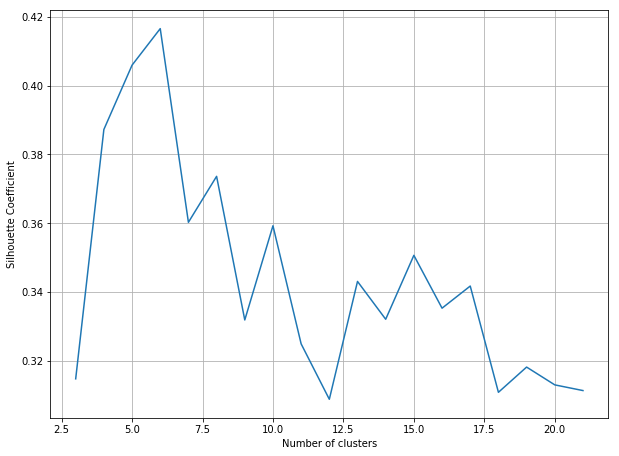

In [126]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

    We will be using Silhouette Coefficient to get the most scattered cluster i.e. least coeffient 
    to get the outliers.
    
    Here 20 touches the least coefficent.

Using 20 custers as solution we see follwing three regions have least common with other region -

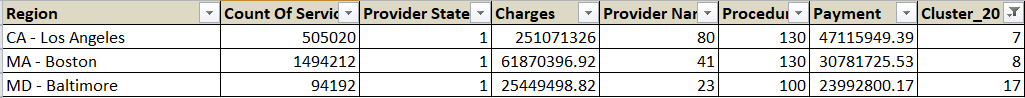

In [127]:
from sklearn.cluster import KMeans

km_20=KMeans(n_clusters=20,random_state=123)
km_20.fit(reduced_cr_1)
km_20.labels_
pd.Series(km_20.labels_).value_counts()

4     63
1     45
2     33
19    29
6     29
0     17
14    16
12    15
15    11
18     9
13     8
3      8
11     6
10     4
16     4
9      4
5      2
8      1
7      1
17     1
dtype: int64

    We see cluster 7, 8 and 17 has only one region each making it least similar to other regions -

Text(0.5,0,u'PC_20')

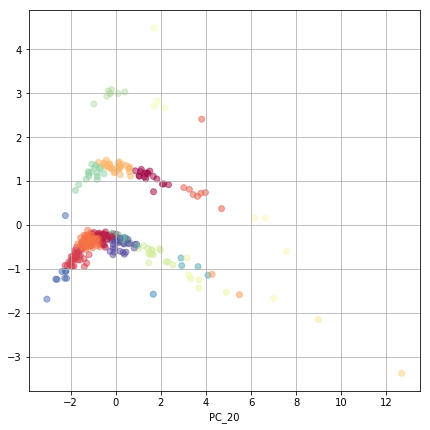

In [128]:
plt.figure(figsize=(7,7))
plt.scatter(reduced_cr_1[:,0], reduced_cr_1[:,1], c=km_20.labels_,cmap='Spectral',alpha=0.5)
plt.xlabel('PC_20')

In [129]:
cluster_df_20=pd.concat([Medicare_data_group_region, pd.Series(km_20.labels_, name='Cluster_20')], axis=1)

In [130]:
cluster_df_20.to_csv('cluster_df_20_1.csv')

     *********************************************** END OF PART 2 ****************************************